# Sorted spike rates

Real datasets:

Simulations: 

* hybrid_janelia
    * 60 recordings, different channel counts and durations, two unique populations
* buccino 2020
    * 10 min neuropixel recording MEAREC hybrid with 250 units (200 excit. 50 inhib.) from BBP's NMC
* npx32  
* npx384  

## Important notes:

SortinExtractor sometimes contain units with no spikes after sorting with Kilosort3. Samuel Garcia's explanation: The question should be ask to autor of kilosort but here a possible explanation.
kilosort use internally template matching which have 2 steps: 1. discover a catalogue of possible template 2. assign every spike to a template.
Maybe in step 1 two very similar templates are "discoverd" and in step 2 all spikes could be assigned to the first one only [(see issue)](https://github.com/SpikeInterface/spikeinterface/issues/1942#issuecomment-1696880268).

## Setup

Activate `spikeforest` environment

```bash
# One-time initialization and follow instructions
kachery-cloud-init
```

In [61]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
import spikeforest as sf
import spikeinterface as si
import warnings
import logging

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
from src.nodes.study import spikestats
from src.nodes.postpro.allen_cell_types import load_session_data, get_optotagged_neurons, get_spont_firing_rates, load_all_sorted_spont_firing_rates
from src.nodes.postpro.npx_cell_types import get_interneurons

# IN-VIVO DATASETS

# allen neuropixels
EXPERIMENT = "supp/allen_neuropixels"  # the experiment 
SIMULATION_DATE = "2023_08_30"    # the run (date)
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()
RAW_DATA = data_conf["raw_data"]["input"]
manifest_path = os.path.join(RAW_DATA, "manifest.json")
PARV_SESSION_ID = 829720705 # parvalbumin tagged data
SST_SESSION_ID = 839068429  # somatostatin tagged data
VIP_SESSION_ID = 835479236  # vip tagged data

# IN-SILICO DATASETS

# HYBRID JANELIA
# we select 20th recording in spikeforest: "rec_64c_600s_12" (64 channels, 600 secs)
EXPERIMENT = "supp/hybrid_janelia"       # specifies the experiment 
SIMULATION_DATE = "2023_06_10"      # specifies the run (date)
data_conf_janelia, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
JANELIA_FR_FILE_PATH = data_conf_janelia["sorting"]["ground_truth"]["firing_rates"]

# BUCCINO 2020
EXPERIMENT = "buccino_2020"
SIMULATION_DATE = "2020"
data_conf_bucci, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
BUCCI_RECORDING_PATH = data_conf_bucci["preprocessing"]["output"]["trace_file_path"]
BUCCI_SORTED_PATH = data_conf_bucci["sorting"]["sorters"]["kilosort3"]["output"]
BUCCI_SORTED_FR_FILE_PATH = data_conf_bucci["features"]["sorted_ks3"]["firing_rates"]

# npx32
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
data_conf32, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
npx32_RECORDING_PATH = data_conf32["preprocessing"]["output"]["trace_file_path"]
npx32_SORTED_PATH = data_conf32["sorting"]["sorters"]["kilosort3"]["output"]
npx32_SORTED_FR_FILE_PATH = data_conf32["features"]["sorted_ks3"]["firing_rates"]

# npx384
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_08_17"
data_conf384, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
npx384_RECORDING_PATH = data_conf384["preprocessing"]["output"]["trace_file_path"]
npx384_SORTED_PATH = data_conf384["sorting"]["sorters"]["kilosort3"]["output"]
npx384_SORTED_FR_FILE_PATH = data_conf384["features"]["sorted_ks3"]["firing_rates"]
npx384_MATCH_FILE = data_conf384["sorting"]["sorters"]["kilosort3"]["match_with_cell_type"]

# silence info and warnings
warnings.filterwarnings('ignore')
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plot real data spike rates

#### Load

In [62]:
# takes 4 min

# get all firing rates

# from a Parv mice
session_parv = load_session_data(PARV_SESSION_ID, manifest_path)
all_firing_rates_parv_mice = load_all_sorted_spont_firing_rates(session_parv, "VIS")

# from a SST mice
session_sst = load_session_data(SST_SESSION_ID, manifest_path)
all_firing_rates_sst_mice = load_all_sorted_spont_firing_rates(session_sst, "VIS")

# from a vip mice
session_vip = load_session_data(VIP_SESSION_ID, manifest_path)
all_firing_rates_vip_mice = load_all_sorted_spont_firing_rates(session_vip, "VIS")

In [63]:
# get firing rates for all vs. FFI removed

# get firing rates of all neurons except FFI
parv_neurons = get_optotagged_neurons(session_parv)
parv_non_FFI = set(all_firing_rates_parv_mice.index) - set(parv_neurons)
parv_ffi_removed_fr = get_spont_firing_rates(session_parv, parv_non_FFI)

# get firing rates of all neurons except FFI
sst_neurons = get_optotagged_neurons(session_sst)
sst_non_FFI = set(all_firing_rates_sst_mice.index) - set(sst_neurons)
sst_ffi_removed_fr = get_spont_firing_rates(session_sst, sst_non_FFI)

# get firing rates of all neurons except FFI
vip_neurons = get_optotagged_neurons(session_vip)
vip_non_FFI = set(all_firing_rates_vip_mice.index) - set(vip_neurons)
vip_ffi_removed_fr = get_spont_firing_rates(session_vip, vip_non_FFI)

# unit-test
assert len(parv_ffi_removed_fr) == len(set(all_firing_rates_parv_mice.index)) - len(
    set(parv_neurons)
), "else something's wrong"
assert len(sst_ffi_removed_fr) == len(set(all_firing_rates_sst_mice.index)) - len(
    set(sst_neurons)
), "else something's wrong"
assert len(vip_ffi_removed_fr) == len(set(all_firing_rates_vip_mice.index)) - len(
    set(vip_neurons)
), "else something's wrong"

#### Plot (Buzsaki-style)

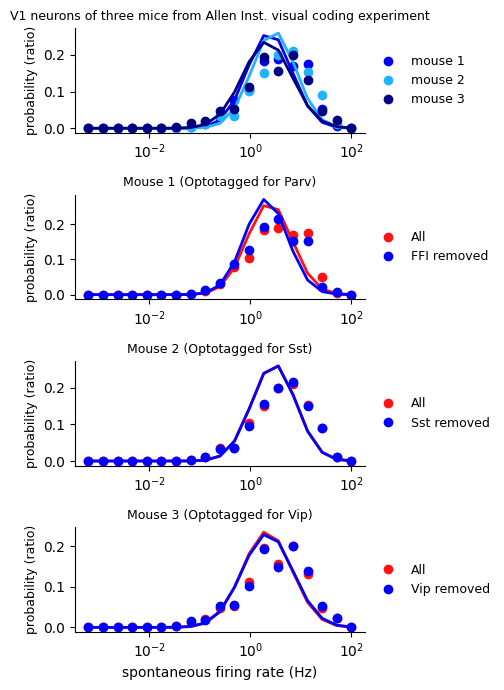

In [64]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 30 # seconds until experimenter decides a cell is silent
t_dec = 1 ^ 100  # seconds until experimenter decides a cell is silent

# plot all neurons for 3 mice (pv, sst, vip)
# -----------------------------------------

fig, axes = plt.subplots(4, 1, figsize=(5, 7))

# allen neuropixels mice 1 (parvalbumin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_parv_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="mouse 1",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)

# allen neuropixels mice 2 (somatostatin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_sst_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="mouse 2",
    color=(0.13, 0.70, 1),
    markerfacecolor=(0.13, 0.70, 1),
    markeredgecolor=(0.13, 0.70, 1),
)

# allen neuropixels mice 2 (somatostatin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_vip_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="mouse 3",
    color=(0, 0, 0.5),
    markerfacecolor=(0, 0, 0.5),
    markeredgecolor=(0, 0, 0.5),
)

# legend
axes[0].set_title(
    "V1 neurons of three mice from Allen Inst. visual coding experiment", fontsize=9
)
axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[0].set_ylabel("probability (ratio)", fontsize=9)


# plot all vs. FFI removed
# ------------------------

# mouse 1 (parvalbumin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_parv_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label="All",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label="FFI removed",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[1].set_ylabel("probability (ratio)", fontsize=9)
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[1].set_title("Mouse 1 (Optotagged for Parv)", fontsize=9)

# mouse 2 (sst tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_sst_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label="All",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label="Sst removed",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[2].set_ylabel("probability (ratio)", fontsize=9)
axes[2].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[2].set_title("Mouse 2 (Optotagged for Sst)", fontsize=9)

# mouse 3 (vip tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_vip_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label="All",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label="Vip removed",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[3].set_ylabel("probability (ratio)", fontsize=9)
axes[3].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[3].set_title("Mouse 3 (Optotagged for Vip)", fontsize=9)

# plt.tight_layout()

#### plot "All except interneurons" vs. interneurons

In [65]:
# get firing rates for all vs. FFI removed

# get firing rates of all neurons except FFI
parv_neurons = get_optotagged_neurons(session_parv)
parv_fr = get_spont_firing_rates(session_parv, parv_neurons)

# get firing rates of all neurons except FFI
sst_neurons = get_optotagged_neurons(session_sst)
sst_fr = get_spont_firing_rates(session_sst, sst_neurons)

# get firing rates of all neurons except FFI
vip_neurons = get_optotagged_neurons(session_vip)
vip_fr = get_spont_firing_rates(session_vip, vip_neurons)

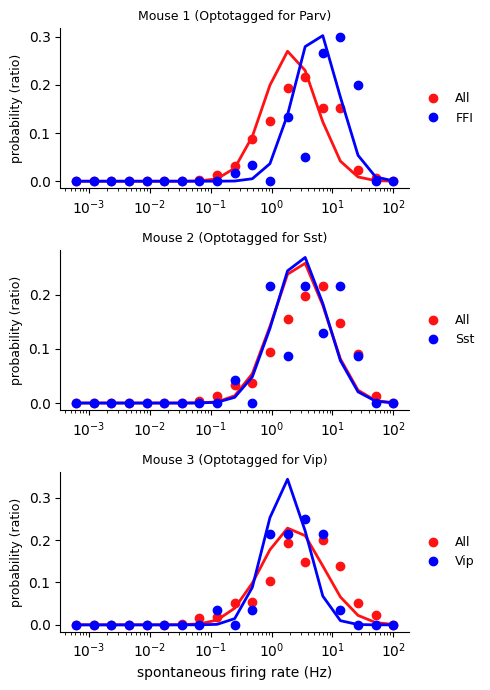

In [66]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 30 # seconds until experimenter decides a cell is silent
t_dec = 1 ^ 100  # seconds until experimenter decides a cell is silent

fig, axes = plt.subplots(3, 1, figsize=(5, 7))

# mouse 1 (parvalbumin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="All",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="FFI",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[0].set_ylabel("probability (ratio)", fontsize=9)
axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[0].set_title("Mouse 1 (Optotagged for Parv)", fontsize=9)

# mouse 2 (sst tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label="All",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label="Sst",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[1].set_ylabel("probability (ratio)", fontsize=9)
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[1].set_title("Mouse 2 (Optotagged for Sst)", fontsize=9)

# mouse 3 (vip tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label="All",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label="Vip",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[2].set_ylabel("probability (ratio)", fontsize=9)
axes[2].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[2].set_title("Mouse 3 (Optotagged for Vip)", fontsize=9)

plt.tight_layout()

### Plot same for npx384

In [67]:
# get neurons by cell types
import pandas as pd

matching = pd.read_csv(npx384_MATCH_FILE)

# drop duplicates sorted units
sorted_neurons = matching[["sorted", "cell_type"]]
sorted_neurons = sorted_neurons.drop_duplicates()

# get all except FFI
not_parv_neurons = sorted_neurons[sorted_neurons["cell_type"] != "parv"][
    "sorted"
].values
parv_neurons = sorted_neurons[sorted_neurons["cell_type"] == "parv"]["sorted"].values

# get all except sst
not_sst_neurons = sorted_neurons[sorted_neurons["cell_type"] != "sst"]["sorted"].values
sst_neurons = sorted_neurons[sorted_neurons["cell_type"] == "sst"]["sorted"].values

# get all except vip
not_vip_neurons = sorted_neurons[sorted_neurons["cell_type"] != "vip"]["sorted"].values
vip_neurons = sorted_neurons[sorted_neurons["cell_type"] == "vip"]["sorted"].values

In [68]:
# get firing rates of all neurons except FFI
not_parv_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    not_parv_neurons,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)
parv_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    parv_neurons,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)

# get firing rates of all neurons except sst
not_sst_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    not_sst_neurons,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)
sst_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    sst_neurons, data_conf384, npx384_RECORDING_PATH, npx384_SORTED_PATH, [], save=False
)

# get firing rates of all neurons except vip
not_vip_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    not_vip_neurons,
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    [],
    save=False,
)
vip_fr_npx384 = spikestats.compute_sorted_spike_rate_for_unit_ids_npx(
    vip_neurons, data_conf384, npx384_RECORDING_PATH, npx384_SORTED_PATH, [], save=False
)

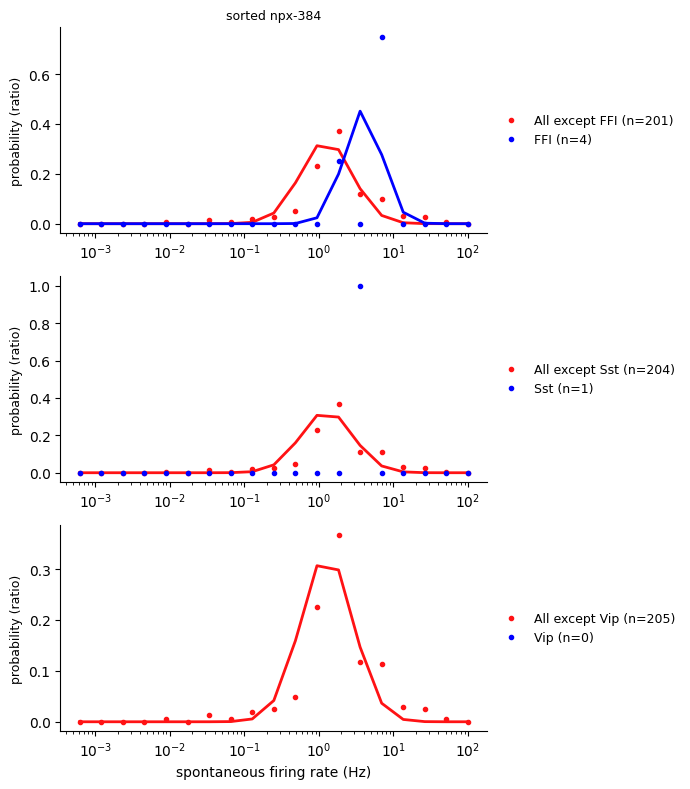

In [124]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 30 # seconds until experimenter decides a cell is silent
t_dec = 1 ^ 100  # seconds until experimenter decides a cell is silent

fig, axes = plt.subplots(3, 1, figsize=(7, 8))

# mouse 1 (parvalbumin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    not_parv_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"All except FFI (n={len(not_parv_fr_npx384)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    parv_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"FFI (n={len(parv_fr_npx384)})",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[0].set_ylabel("probability (ratio)", fontsize=9)
axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[0].set_title("sorted npx-384", fontsize=9)

# mouse 2 (sst tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    not_sst_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"All except Sst (n={len(not_sst_fr_npx384)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    sst_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"Sst (n={len(sst_fr_npx384)})",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[1].set_ylabel("probability (ratio)", fontsize=9)
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

# mouse 3 (vip tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    not_vip_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"All except Vip (n={len(not_vip_fr_npx384)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)
spikestats.plot_firing_rate_hist_ground_truths(
    vip_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"Vip (n={len(vip_fr_npx384)})",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)
axes[2].set_ylabel("probability (ratio)", fontsize=9)
axes[2].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)

plt.tight_layout()

#### On the same plot 

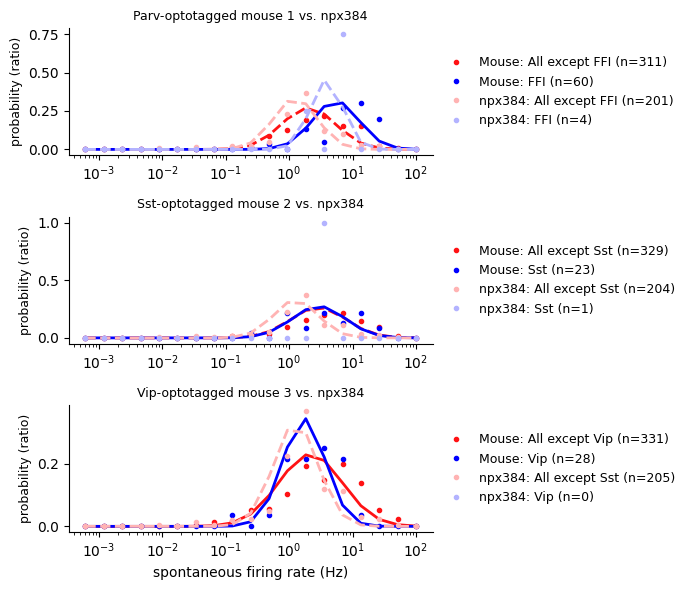

In [115]:
# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 30 # seconds until experimenter decides a cell is silent
t_dec = 1 ^ 100  # seconds until experimenter decides a cell is silent

fig, axes = plt.subplots(3, 1, figsize=(7, 6))

# mouse 1 (parvalbumin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"Mouse: All except FFI (n={len(parv_ffi_removed_fr)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
    linestyle="--",
    markersize=3,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(parv_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"Mouse: FFI (n={len(parv_fr)})",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
    linestyle="-",
    markersize=3,
)

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    not_parv_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"npx384: All except FFI (n={len(not_parv_fr_npx384)})",
    color=(1, 0.7, 0.7),
    markerfacecolor=(1, 0.7, 0.7),
    markeredgecolor=(1, 0.7, 0.7),
    linestyle="--",
    markersize=3,
)
spikestats.plot_firing_rate_hist_ground_truths(
    parv_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"npx384: FFI (n={len(parv_fr_npx384)})",
    color=(0.7, 0.7, 1),
    markerfacecolor=(0.7, 0.7, 1),
    markeredgecolor=(0.7, 0.7, 1),
    linestyle="--",
    markersize=3,
)

axes[0].set_ylabel("probability (ratio)", fontsize=9)
axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[0].set_title("Parv-optotagged mouse 1 vs. npx384", fontsize=9)

# mouse 2 (Sst tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"Mouse: All except Sst (n={len(sst_ffi_removed_fr)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
    linestyle="--",
    markersize=3,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(sst_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"Mouse: Sst (n={len(sst_fr)})",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
    linestyle="-",
    markersize=3,
)

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    not_sst_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"npx384: All except Sst (n={len(not_sst_fr_npx384)})",
    color=(1, 0.7, 0.7),
    markerfacecolor=(1, 0.7, 0.7),
    markeredgecolor=(1, 0.7, 0.7),
    linestyle="--",
    markersize=3,
)
spikestats.plot_firing_rate_hist_ground_truths(
    sst_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"npx384: Sst (n={len(sst_fr_npx384)})",
    color=(0.7, 0.7, 1),
    markerfacecolor=(0.7, 0.7, 1),
    markeredgecolor=(0.7, 0.7, 1),
    linestyle="--",
    markersize=3,
)

axes[1].set_ylabel("probability (ratio)", fontsize=9)
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[1].set_title("Sst-optotagged mouse 2 vs. npx384", fontsize=9)


# mouse 2 (Sst tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_ffi_removed_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"Mouse: All except Vip (n={len(vip_ffi_removed_fr)})",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
    linestyle="-",
    markersize=3,
)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(vip_fr),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"Mouse: Vip (n={len(vip_fr)})",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
    linestyle="-",
    markersize=3,
)

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    not_vip_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"npx384: All except Sst (n={len(not_vip_fr_npx384)})",
    color=(1, 0.7, 0.7),
    markerfacecolor=(1, 0.7, 0.7),
    markeredgecolor=(1, 0.7, 0.7),
    linestyle="--",
    markersize=3,
)
spikestats.plot_firing_rate_hist_ground_truths(
    vip_fr_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"npx384: Vip (n={len(vip_fr_npx384)})",
    color=(0.7, 0.7, 1),
    markerfacecolor=(0.7, 0.7, 1),
    markeredgecolor=(0.7, 0.7, 1),
    linestyle="--",
    markersize=3,
)

axes[2].set_ylabel("probability (ratio)", fontsize=9)
axes[2].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[2].set_title("Vip-optotagged mouse 3 vs. npx384", fontsize=9)

plt.tight_layout()

### Plot model population sorted rates

#### Compute rates

In [118]:
# Buccino 2020
sorted_rates_buccino2020 = spikestats.compute_sorted_spike_rate_buccino2020(
    BUCCI_RECORDING_PATH, BUCCI_SORTED_PATH, BUCCI_SORTED_FR_FILE_PATH, save=True
)

# npx32
sorted_rates_npx32 = spikestats.compute_sorted_spike_rate_npx(
    data_conf32,
    npx32_RECORDING_PATH,
    npx32_SORTED_PATH,
    npx32_SORTED_FR_FILE_PATH,
    save=True,
)

# npx384
sorted_rates_npx384 = spikestats.compute_sorted_spike_rate_npx(
    data_conf384,
    npx384_RECORDING_PATH,
    npx384_SORTED_PATH,
    npx384_SORTED_FR_FILE_PATH,
    save=True,
)


Buccino_2020


#### Plot

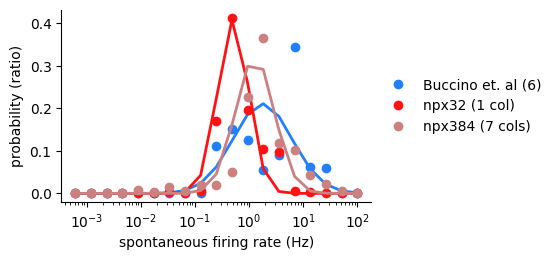

In [42]:
ax = plt.figure(figsize=(4, 2.5)).gca()

# monotrode
# spikestats.plot_firing_rate_hist_ground_truths(firing_rates_monotrode, log_x_min, log_x_max, nbins, t_dec, ax, label="synth monotrode (5)",color = (1, 0.50, 0.2) , markerfacecolor=(1, 0.50, 0.2), markeredgecolor=(1, 0.50, 0.2))

# buccino 2020
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_rates_buccino2020,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label="Buccino et. al (6)",
    color=(0.13, 0.50, 1),
    markerfacecolor=(0.13, 0.50, 1),
    markeredgecolor=(0.13, 0.50, 1),
)

# npx32
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_rates_npx32,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label="npx32 (1 col)",
    color=(1, 0.07, 0.08),
    markerfacecolor=(1, 0.07, 0.08),
    markeredgecolor=(1, 0.07, 0.08),
)

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_rates_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    ax,
    label="npx384 (7 cols)",
    color=(0.8, 0.5, 0.5),
    markerfacecolor=(0.8, 0.5, 0.5),
    markeredgecolor=(0.8, 0.5, 0.5),
)

# janelia
# spikestats.plot_firing_rate_hist_ground_truths(firing_rates_janelia, log_x_min, log_x_max, nbins, t_dec, ax, label="hybrid janelia (7)", color=(0.75, 0.8, 0.34), markerfacecolor=(0.38, 0.70, 0), markeredgecolor=(0.38, 0.70, 0))

# save figures
# plt.savefig("figures/2_realism/4_firing_rate/pdf/sorted_firing_rate_dist.pdf")
# plt.savefig("figures/2_realism/4_firing_rate/svg/sorted_firing_rate_dist.svg")

Text(0, 0.5, 'probability (ratio)')

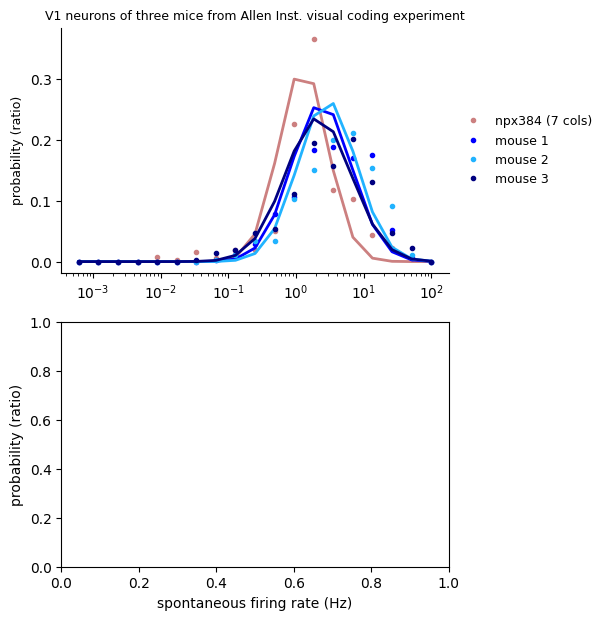

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(5, 7))

# npx384
spikestats.plot_firing_rate_hist_ground_truths(
    sorted_rates_npx384,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="npx384 (7 cols)",
    color=(0.8, 0.5, 0.5),
    markerfacecolor=(0.8, 0.5, 0.5),
    markeredgecolor=(0.8, 0.5, 0.5),
)

# allen neuropixels mice 1 (parvalbumin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_parv_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="mouse 1",
    color=(0, 0, 1),
    markerfacecolor=(0, 0, 1),
    markeredgecolor=(0, 0, 1),
)

# allen neuropixels mice 2 (somatostatin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_sst_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="mouse 2",
    color=(0.13, 0.70, 1),
    markerfacecolor=(0.13, 0.70, 1),
    markeredgecolor=(0.13, 0.70, 1),
)

# allen neuropixels mice 2 (somatostatin tagged)
spikestats.plot_firing_rate_hist_ground_truths(
    np.array(all_firing_rates_vip_mice),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label="mouse 3",
    color=(0, 0, 0.5),
    markerfacecolor=(0, 0, 0.5),
    markeredgecolor=(0, 0, 0.5),
)

# legend
axes[0].set_title(
    "V1 neurons of three mice from Allen Inst. visual coding experiment", fontsize=9
)
axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
axes[0].set_ylabel("probability (ratio)", fontsize=9)

In [121]:
# get interneuron types
parv_neurons_npx384 = get_interneurons(data_conf384, "LBC|NBC")
sst_neurons_npx384 = get_interneurons(data_conf384, "MC")
vip_neurons_npx384 = get_interneurons(data_conf384, "SBC")

array([], dtype=int64)